In [23]:
# Design specifications and material properties

import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.integrate import solve_bvp
from scipy.integrate import quad
from scipy.optimize import fsolve
from scipy.optimize import minimize_scalar

# Fuel assembly (FA) representative of average core conditions
P_FA = 6.641 #[MW] Fuel assembly thermal power
N_FP = 284 #[pin] Number of fuel pins in the fuel assembly
q_l0 = 26.03 #[kW/m] Linear heat rate at fuel midplane, q'(0)
pitch = 13.6 #[mm] Pin pitch
T_co_in = 400 #[°C] Coolant inlet temperature
T_co_out = 480 #[°C] Coolant outlet temperature

# Coolant properties (uniform along the channel) - Liquid Pb
cp_co = 146 #[J/kg-°C] Average heat capacity
rho_co = 10520 #[kg/m^3] Average density
mu_co = 0.002 #[Pa-s] Average dynamic viscosity
k_co = 15.5 #[W/m-°C] Average thermal conductivity

# Fuel pins
D_clad_ext = 8.50 #[mm] External diameter of cladding
t_clad = 0.600 #[mm] Cladding thickness
H_act = 1100 #[mm] Active length
H_tot = 2100 #[mm] Total length

# Fuel - solid pellets (MOX)
TD_fuel = 11.31 #[g/cm^3] Theoretical density of MOX fuel
rho_fuel = 0.88*TD_fuel #[g/cm^3] Density of fuel
T_fuel_melt = 2730 #[°C] Melting temperature of fresh fuel
D_fuel = 6.98 #[mm] Fuel pellet diameter
alpha_l_fuel = 12e-6 #[°C^-1] Linear coefficient of thermal expansion (T_ref = 25°C)
Y_fuel = 170 #[GPa] Young's modulus of solid pellets
nu_poisson_fuel = 0.31 #[/] Poisson's coefficient

# Cladding - Ferritic-martensitic steel T91 (UNS No. K90901)
T_clad_melt = 1500 #[°C] Melting temperature of cladding
k_clad = 28.7 #[W/m-°C] Average thermal conductivity of cladding
alpha_l_clad = 12e-6 #[°C^-1] Linear coefficient of thermal expansion (T_ref = 25°C)
Y_clad = 170 #[GPa] Young's modulus of cladding
nu_poisson_clad = 0.3 #[/] Poisson's coefficient
#SY_clad = 563.1 - 4.878e-1*T_clad + 1.6e-3*T_clad**2 - 3e-6*T_clad**3 + 8e-10*T_clad**4 #[MPa] Yield strength of cladding

In [24]:
# COLD GEOMETRY ANALYSIS
# (I)

# Coolant mass flowrate  (square channel 1/4*4 fuel pins = 1 fuel pin)
P_FP = P_FA/N_FP #[MW/pin] Average thermal power per fuel pin
m_co = P_FP/(cp_co*(T_co_out - T_co_in))*1e6 #[kg/s] Average coolant mass flowrate per channel
volflow_co = m_co/rho_co #[m^3/s] Average volumetric flow of coolant per channel
print('Average thermal power per fuel pin:',P_FP,'[MW/pin]')
print('Average coolant mass flowrate per channel:',m_co,'[kg/s]')

# Geometry of channel
A_channel = pitch**2-(np.pi*D_clad_ext**2/4) #[mm^2] Area channel
P_w = np.pi*D_clad_ext #[mm] Wet perimeter
D_h = 4*A_channel/P_w/1000 #[m] Hydraulic diameter of channel
print('Hydraulic diameter of channel:',D_h, '[m]')

# Calculation of velocity of coolant in channel
v_co = volflow_co/(A_channel/1e6) #[m/s] Average velocity of coolant in channel
print('Average velocity of coolant in channel',v_co,'[m/s]')

# Reynolds number of coolant
Re_co = rho_co*v_co*D_h/mu_co #[/]
print('Reynolds number of coolant:', Re_co)

# Darcy factor
f_darcy=0.184*Re_co**(-0.20)
print('Darcy factor of coolant per channel:', f_darcy)

# Calculation of Prandtl number
Pr_co = mu_co*cp_co/k_co #[/]
print('Prandtl number of coolant:', Pr_co)

# Calculation of Peclet number
Pe_co = Re_co*Pr_co #[/]
print('Peclet number of coolant:', Pe_co)

# Calculation of Nusselt number
x = pitch/D_clad_ext #[/] Pin-pitch to cladding outer diameter ratio
print('Pin-pitch to cladding outer diameter ratio:', x)
Nu_co_1 = 0.58*(D_h/(D_clad_ext/1000))**0.55*Pe_co**0.45 #discarded x value out of range
Nu_co = 4.5 + 0.014*Pe_co**0.8
print('Nusselt1 number of coolant:', Nu_co_1)
print('Nusselt number of coolant:', Nu_co)

# Heat transfer coefficient of coolant
h_co = Nu_co*k_co/D_h #[W/m^2-°C]
print('Heat transfer coefficient of coolant:', h_co, '[W/m^2-°C]')

Average thermal power per fuel pin: 0.02338380281690141 [MW/pin]
Average coolant mass flowrate per channel: 2.0020379124059424 [kg/s]
Hydraulic diameter of channel: 0.01920569249343714 [m]
Average velocity of coolant in channel 1.4842866438142674 [m/s]
Reynolds number of coolant: 149945.52000789868
Darcy factor of coolant per channel: 0.01696801830703975
Prandtl number of coolant: 0.018838709677419355
Peclet number of coolant: 2824.7801188584785
Pin-pitch to cladding outer diameter ratio: 1.5999999999999999
Nusselt1 number of coolant: 32.439724710137625
Nusselt number of coolant: 12.570784551614757
Heat transfer coefficient of coolant: 10145.281697945067 [W/m^2-°C]


In [25]:
# COLD GEOMETRY ANALYSIS
# (II)

# Average linear heat rate
q_l_av = P_FP*1000/(H_act/1000) #[kW/m]
print('Average linear heat rate', q_l_av, '[kW/m]')

# Axial linear heat rate distribution [kW]
def q_l(z, H_ext):
    return q_l0 * np.cos(np.pi * z / H_ext)

# Average power per half fuel pin
int_q_l = (P_FP*1000)/2 #[kW] Integral from z=0 to z=H_ext is equal to the half of average power of 1 fuel pin
print('Fuel power of half pin fuel:',int_q_l,'[kW]')

# Define a function for the integral and the target value
def integral_eq(H_ext):
    # Compute the integral of q_l from 0 to H_ext
    integral, _ = quad(q_l, 0, H_ext/2, args=(H_ext,))
    return integral - int_q_l  # Return the difference from the target value

# Use fsolve to solve for H_ext that satisfies the integral equation
H_ext_solution = fsolve(integral_eq, 1.0)  # Initial guess for H_ext
H_ext = H_ext_solution[0]

print('Extrapolated boundary:', H_ext, "[m]")

Average linear heat rate 21.25800256081946 [kW/m]
Fuel power of half pin fuel: 11.691901408450704 [kW]
Extrapolated boundary: 1.4111099335875872 [m]


In [26]:
# Verification of extrapolated length
z = H_ext/2
a = np.cos(np.pi * z/H_ext) #a should be zero
print(f"Cos(***): {a}")

# Axial linear heat rate distribution [kW]
def q_l2(z):
    return q_l0 * np.cos(np.pi * z / H_ext)

# Evaluate the function at different values of z
z1 = 0
z2 = H_ext/2
print(f"q_l2(z = {z1} [m]) = {q_l2(z1)} [kW/m]")  #corresponds to qo given
print(f"q_l2(z = {z2} [m]) = {q_l2(z2)} [kW/m]")  #should be 0 in the extrapolated border

# Calculate the integral from 0 to H_ext
result, error = quad(q_l2, 0, z2)
print('Average thermal power per fuel pin:',P_FP*1000,'[kW/pin]')
print("Integral result:", 2*result,'[kW/pin]')
print("Estimated error:", error)

Cos(***): 6.123233995736766e-17
q_l2(z = 0 [m]) = 26.03 [kW/m]
q_l2(z = 0.7055549667937936 [m]) = 1.5938778090902803e-15 [kW/m]
Average thermal power per fuel pin: 23.383802816901408 [kW/pin]
Integral result: 23.38380281690141 [kW/pin]
Estimated error: 1.298061814530927e-13


Outer cladding temperature: 536.08 [°C]
Inner cladding temperature: 558.05 [°C]


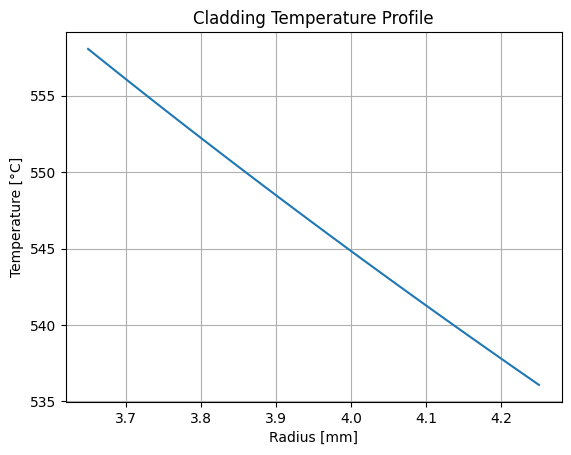

In [27]:
# Cladding temperature profile at midplane

# Geometry of cladding
r_clad_out = D_clad_ext/2 #[mm] External radius of cladding
r_clad_in = r_clad_out - t_clad #[mm] Internal radius of cladding

# Outer cladding temperature
T_co_avg0 = (T_co_in + T_co_out) / 2 #[°C] Average temperature of coolant along the channel
T_clad_out = (q_l0 * 1e6 / P_w) / h_co + T_co_avg0 #[°C] Outer cladding temperature
print(f'Outer cladding temperature: {T_clad_out:.2f} [°C]')

# Define temperature profile across cladding
def T_clad(r_clad):
    C = T_clad_out + (q_l0 * 1e3 * r_clad_out * np.log(r_clad_out)) / (P_w * k_clad)
    return -(q_l0 * 1e3 * r_clad_out  * np.log(r_clad)) / (P_w * k_clad) + C

# Define the range of r values
r_clad_values = np.linspace(r_clad_in, r_clad_out, 100)  #values along cladding thickness

# Calculate the temperature profile
T_clad_values = T_clad(r_clad_values)

# Inner cladding temperature
T_clad_in = T_clad(r_clad_in)
print(f'Inner cladding temperature: {T_clad_in:.2f} [°C]')

# Plot the results
plt.plot(r_clad_values, T_clad_values)
plt.title('Cladding Temperature Profile')
plt.xlabel('Radius [mm]')
plt.ylabel('Temperature [°C]')
plt.grid()
plt.show()

Outer temperature of the gap at cladding side: 558.05 [°C]
Inner temperature of the gap at fuel side: 1075.84 °C


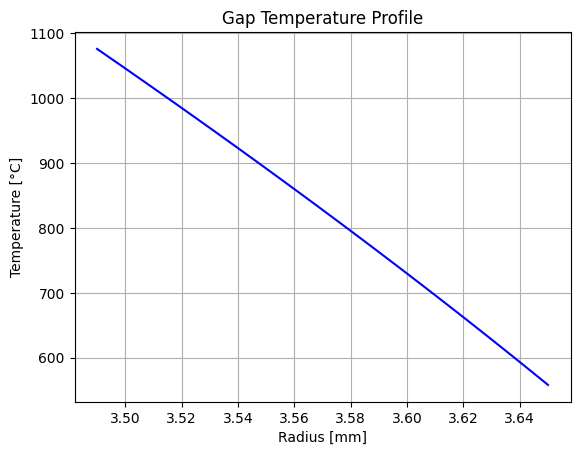

In [28]:
# Gap temperature profile at midplane

# Define constants
T_gap_out = T_clad_in #[°C] Outer temperature of the gap at cladding side
r_gap_out = r_clad_in #[mm] Outer radius of the gap
r_gap_in = D_fuel/2 #[mm] Inner radius of the gap
T_gap_out_K = T_gap_out + 273.15 #[K] Outer temperature of gap
print(f'Outer temperature of the gap at cladding side: {T_gap_out:.2f} [°C]')

# Define thermal profile of gap
def T_gap_K(r_gap):
    C = (2*T_gap_out_K)**1.79 + (1.79*2**0.79) * (q_l0 * 1e3 * r_clad_out * np.log(r_gap_out)) / (P_w * 15.8e-4)
    return (- (1.79*2**0.79) * (q_l0 * 1e3 * r_clad_out * np.log(r_gap)) / (P_w * 15.8e-4) + C)**(1/1.79) - T_gap_out_K

# Define r_gap values
r_gap_values = np.linspace(r_gap_in, r_gap_out, 100) #[mm]

# Solve the temperature profile
T_gap_C_values = T_gap_K(r_gap_values) - 273.15 #[°C]

# Print inner gap temperature
T_gap_in = T_gap_K(r_gap_in) - 273.15 #[°C]
print(f'Inner temperature of the gap at fuel side: {T_gap_in:.2f} °C')

# Plot the results
plt.plot(r_gap_values, T_gap_C_values, color='blue')
plt.title('Gap Temperature Profile')
plt.xlabel('Radius [mm]')
plt.ylabel('Temperature [°C]')
plt.grid()
plt.show()

Temperature of fuel at surface: 1075.8414426032673 [°C]
Average thermal conductivity of fuel: 2.049999999999997 [W/m-°C]
Maximum temperature at fuel: 2086.2812398427895 [°C]


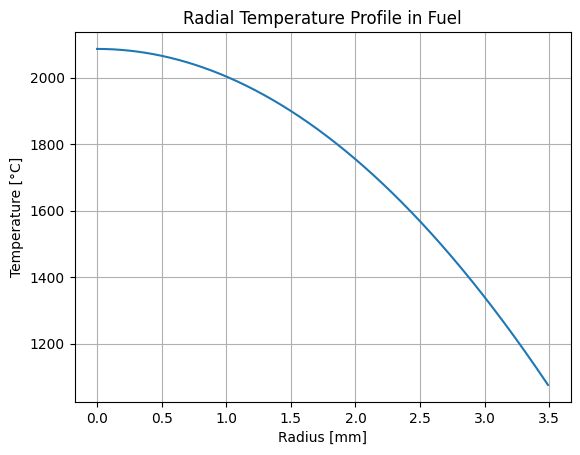

In [29]:
# Radial temperature profile at midplane of Fuel

# Define constants
T_fuel_out = T_gap_in #[°C] Outer temperature of the gap at cladding side
r_fuel_out = D_fuel/2 #[mm] Fuel radius
print('Temperature of fuel at surface:',T_fuel_out, '[°C]')

# Rough estimation of conductivity from graph
T_fuel_2 = 2200 #[°C]
int_k_fuel_2 = 63.8 #[W/cm]
T_fuel_1 = 2000 #[°C]
int_k_fuel_1 = 59.7 #[W/cm]
k_fuel_avg = (int_k_fuel_2 - int_k_fuel_1) / (T_fuel_2 - T_fuel_1) * 100 #[W/m-°C] Average thermal conductivity of fuel
print('Average thermal conductivity of fuel:',k_fuel_avg, '[W/m-°C]')

# Define C1
C1 = (q_l0 * 1e3 )/ (4 * np.pi * k_fuel_avg) #[°C]

# Define the temperature profile function
def T_fuel(r_fuel):
    F_v = (1-(r_fuel/r_fuel_out)**2)
    return T_fuel_out + C1 * F_v

# Define the range of r_fuel values (from 0 to r_fuel_ext, in mm)
r_fuel_values = np.linspace(0, r_fuel_out, 1000)  # r_fuel is in mm

# Calculate the temperature profile
T_fuel_values = T_fuel(r_fuel_values)

# Calculate the maximum temperature
print(f'Maximum temperature at fuel: {T_fuel(0)} [°C]')

# Plot the results
plt.plot(r_fuel_values, T_fuel_values)  # r_fuel is already in mm
plt.title('Radial Temperature Profile in Fuel')
plt.xlabel('Radius [mm]')
plt.ylabel('Temperature [°C]')
plt.grid()
plt.show()

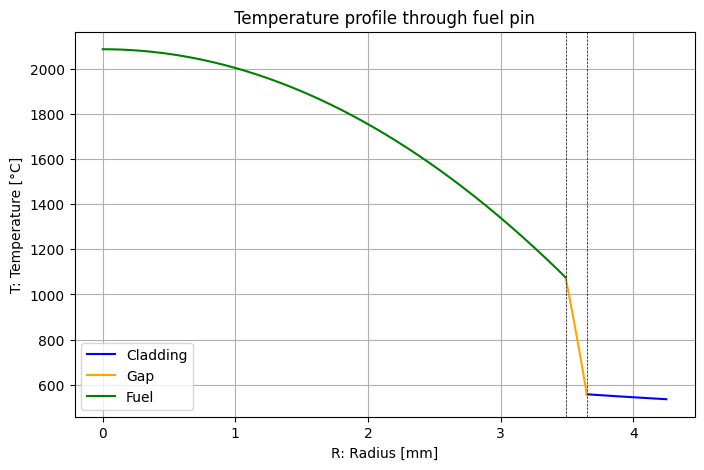

In [30]:
# Temperature profile plot

# Plotting multiple graphs
plt.figure(figsize=(8, 5))   # Set the figure size
plt.plot(r_clad_values, T_clad_values, label = 'Cladding', color = 'blue')
plt.plot(r_gap_values, T_gap_C_values, label = 'Gap', color = 'orange')
plt.plot(r_fuel_values, T_fuel_values, label = 'Fuel', color = 'green')
plt.title('Temperature profile through fuel pin')
plt.xlabel('R: Radius [mm]')
plt.ylabel('T: Temperature [°C]')
plt.axvline(r_clad_in, color='black',linewidth=0.5, ls='--')
plt.axvline(r_fuel_out, color='black',linewidth=0.5, ls='--')
plt.grid()
plt.legend()
plt.show()


**II.c,d) Axial temperature profiles of coolant, cladding at outer and inner radius. Axial coordinate where the maximum cladding temperature is reached.**

The axial temperature profile of the coolant was calculated as,

\begin{equation}
T_{cool}(z) = \frac{q_{0}H_{ext}}{m_{cool}cp_{cool}\pi}sin(\frac{\pi z}{H_{ext}}) + C
\end{equation}

with

\begin{equation}
C = T_{cool,in} - \frac{q_{0}H_{ext}}{m_{cool}cp_{cool}\pi}sin(-\frac{\pi}{2})
\end{equation}

The axial temperature profile of the cladding was calculated by using the temperature difference between the cladding and the coolant at different position. Where,

\begin{equation}
\Delta T_{clad-cool}(z) = T_{clad}(z) - T_{cool}(z) = \frac{q_{0}}{P_w * h_{cool}}cos(\frac{\pi z}{H_{ext}})
\end{equation}

Then, the same process was applied to find the radial temperature profile of the inner side of the cladding by using heat conduction.

\begin{equation}
\Delta T_{clad,r}(z) = T_{clad,in}(z) - T_{clad,out}(z) = \frac{-q_{0}}{2\pi k_{clad}} cos(\frac{\pi z}{H_{ext}}) ln(\frac{r_{clad,out}}{r_{clad,in}})
\end{equation}

Maximum temperature at external wall of cladding: 544.08 [°C] at H = 177.19 [mm]
Maximum temperature at internal wall of cladding: 564.64 [°C] at H = 146.74 [mm]


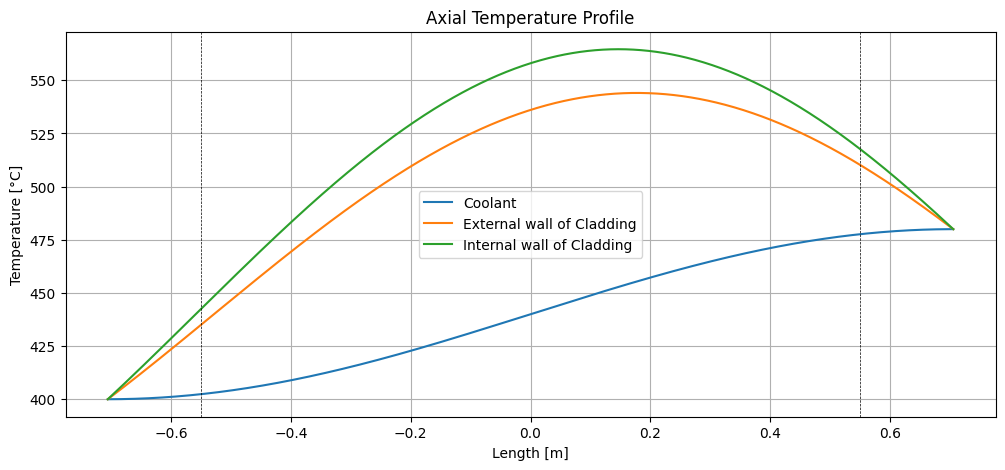

In [31]:
# Axial profile of cladding and coolant

# Define axial profile temperature of coolant
def T_co_z(z):
    C = T_co_in - q_l0 * 1e3 * np.sin(- np.pi / 2) * H_ext / (m_co * cp_co * np.pi)
    return q_l0 * 1e3 * np.sin(np.pi * z / H_ext) * H_ext / (m_co * cp_co * np.pi) + C

# Define axial profile of the difference between outer wall temperature of cladding and coolant
def dT_clad_coolant_z(z):
    return q_l0*1e6 * np.cos(np.pi * z / H_ext) / (P_w * h_co)

# Define axial profile of the difference between outer wall temperature of cladding and inner wall of cladding
def dT_clad_z(z):
    return -q_l0*1e3 * np.cos(np.pi * z / H_ext) * np.log(r_clad_out/r_clad_in)  / (2*np.pi * k_clad)

# Define the range of z_clad values
z_values = np.linspace(-H_ext/2, H_ext/2, 1000)  # z_clad is in [m]

# Calculate the axial temperature profiles
T_co_values = T_co_z(z_values)
T_clad_out_values = dT_clad_coolant_z(z_values) + T_co_z(z_values)
T_clad_in_values = T_clad_out_values - dT_clad_z(z_values)

# Calculate the maximum temperature
T_clad_out_res = minimize_scalar(lambda z: - (dT_clad_coolant_z(z) + T_co_z(z)), bounds=(-H_ext/2, H_ext/2), method='bounded')
T_clad_out_max = dT_clad_coolant_z(T_clad_out_res.x) + T_co_z(T_clad_out_res.x)
T_clad_in_res = minimize_scalar(lambda z: - (dT_clad_coolant_z(z) + T_co_z(z)  - dT_clad_z(z)), bounds=(-H_ext/2, H_ext/2), method='bounded')
T_clad_in_max = dT_clad_coolant_z(T_clad_in_res.x) + T_co_z(T_clad_in_res.x) - dT_clad_z(T_clad_in_res.x)
print(f'Maximum temperature at external wall of cladding: {T_clad_out_max:.2f} [°C] at H = {T_clad_out_res.x*1000:.2f} [mm]')
print(f'Maximum temperature at internal wall of cladding: {T_clad_in_max:.2f} [°C] at H = {T_clad_in_res.x*1000:.2f} [mm]')


# Plot the results
plt.figure(figsize=(12, 5))   # Set the figure size
plt.plot(z_values, T_co_values, label = 'Coolant')  # r_fuel is already in mm
plt.plot(z_values, T_clad_out_values, label = 'External wall of Cladding')  # r_fuel is already in mm
plt.plot(z_values, T_clad_in_values, label = 'Internal wall of Cladding')  # r_fuel is already in mm
plt.title('Axial Temperature Profile')
plt.xlabel('Length [m]')
plt.ylabel('Temperature [°C]')
plt.axvline(-H_act/2/1000, color='black',linewidth=0.5, ls='--')
plt.axvline(H_act/2/1000, color='black',linewidth=0.5, ls='--')
plt.legend()
plt.grid()
plt.show()

**II.e) Radial position of fuel pellet cracking.**

 - The brittle-ductile transition for MOX fuel occurs at 1733 °C.
 - The conductivity of the fuel is $k_{fuel,eff} = 2.5 \frac{W}{mK}$

 The radial temperature profile of the fuel corresponds to:

\begin{equation}
T_{fuel}(r) = T_{fuel,out} + \frac{q_l}{4\pi k_{fuel,eff}}*(1 - (\frac{r}{r_{fuel,out}})^2)
\end{equation}

This equation is optimized to find the $r_{crit}$ where the $T_{fuel}(r_{crit}) = 1733 °C$.

Critical radius (r_c): 1.59 [mm]
Minimal linear heat rate (q_l_min): 21.20 [kW/m]


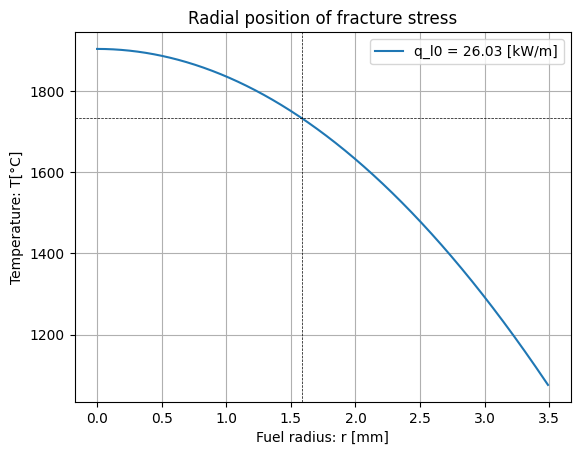

In [32]:
# Minimum linear heat rate that leads pellet thermal cracking

# Define constants
k_fuel_eff = 2.5 #[W/m-K]
T_fuel_brittle_ductile_trans = 1733 #[°C]

# Define the temperature profile function
def T_fuel_local(r_fuel, q_l_f):
    F_v = (1-(r_fuel/r_fuel_out)**2)
    C1 = (q_l_f * 1e3 )/ (4 * np.pi * k_fuel_eff) #[°C]
    T_clad_out_f = (q_l_f * 1e6 / P_w) / h_co + T_co_avg0 #[°C] Outer cladding temperature as a function of linear power
    T_fuel_out_f = T_fuel_out + T_clad_out_f - T_clad_out
    return T_fuel_out_f + C1 * F_v

# Define the equation to solve for critical r_fuel
def r_fuel_crit_f(r_c):
    return T_fuel_local(r_c, q_l0) - T_fuel_brittle_ductile_trans

# Finding the critical radius when q_l0 = 26.03 [kW/m]
r_fuel_crit_initial_guess = 0.005  # Example initial guess for r_c [m]
r_fuel_crit_solution = fsolve(r_fuel_crit_f, r_fuel_crit_initial_guess)
T_fuel_local_values = T_fuel_local(r_fuel_values, q_l0)
print(f"Critical radius (r_c): {r_fuel_crit_solution[0]:.2f} [mm]")

# Define the equation to solve minimal linear heat reate
def q_l_min_f(q_l_m):
    return T_fuel_local(0, q_l_m) - T_fuel_brittle_ductile_trans

# Finding the minimal linear heat rate at center r = 0 [mm]
q_l_min_initial_guess = 26.03  # Example initial guess for q_l[kW/m]
q_l_min_solution = fsolve(q_l_min_f, q_l_min_initial_guess)
print(f"Minimal linear heat rate (q_l_min): {q_l_min_solution[0]:.2f} [kW/m]")

plt.plot(r_fuel_values, T_fuel_local_values, label = 'q_l0 = 26.03 [kW/m]')
plt.title('Radial position of fracture stress')
plt.xlabel('Fuel radius: r [mm]')
plt.ylabel('Temperature: T[°C]')
plt.axvline(r_fuel_crit_solution[0], color='black',linewidth=0.5, ls='--')
plt.axhline(T_fuel_brittle_ductile_trans, color='black',linewidth=0.5, ls='--')
plt.legend()
plt.grid()
plt.show()

**III.a) Hot channel coolant temperature. Hot channel maximum cladding temperature with and without corrosion and its position in the z-axis.**

Given that the outer temperature of the cladding is 544 [°C]. The thickness of the oxide layer is calculated by $\delta_c = 0.26(T_{cladd,out}-380) + 1$, where $\delta_c$ is in $[\mu m]$. Furthermore, the conductivity of the oxide layer is a $k_{corrosion} = 1 \frac{W}{mK}$

The axial temperature profile of the coolant was calculated as,


\begin{equation}
T_{cool}(z) = \frac{q_{0,max}H_{ext}}{m_{cool}cp_{cool}\pi}sin(\frac{\pi z}{H_{ext}}) + C
\end{equation}

with

\begin{equation}
C = T_{cool,in} - \frac{q_{0,max}H_{ext}}{m_{cool}cp_{cool}\pi}sin(-\frac{\pi}{2})
\end{equation}

The axial temperature profile of the cladding was calculated by using the temperature difference between the cladding and the coolant at different position, $\Delta T(z)$. Where,

\begin{equation}
\Delta T(z) = T_{clad}(z) - T_{cool}(z) = \frac{q_{0,max}}{P_w * h_{cool}}cos(\frac{\pi z}{H_{ext}})
\end{equation}

Then, the function $T_{clad}(z)$ was optimized to find the maximum external temperature of the cladding along z. Finally, the radial temperature profiles of the oxide layer and the cladding were calculated by Fick's law. For example,

\begin{equation}
T_{corr}(r) = \frac{-q_{0,max}(r_{clad,out}+\delta_c)}{k_{corr}P_w}ln(r) + C
\end{equation}

with

\begin{equation}
C = T_{clad,out,max} + \frac{q_{0,max}(r_{clad,out}+\delta_c)}{k_{corr}P_w}ln(r_{clad,out}+\delta_c)
\end{equation}

Hot channel outlet coolant temperature: 498.00 [°C]
Maximum temperature of the external wall of cladding at the hot channel: 576.49 [°C] at H = 177.19 [mm]
Temperature of the external wall of cladding at the hottest point considering a layer of corrosion: 639.07 [°C]
Temperature of the internal wall of cladding at the hottest point considering a layer of corrosion: 665.98 [°C]


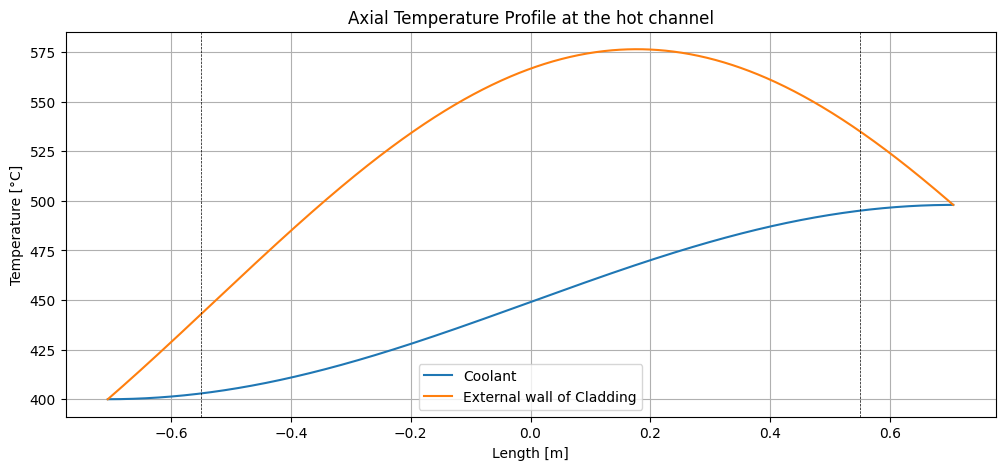

In [33]:
# COLD GEOMETRY ANALYSIS
# (III)

# Given data
peak_factor = 1.5
q_l0_hot = peak_factor * q_l_av #[kW/m]

# Hot channel heat power considering the same H_ext obtained before
P_FP_hot = 2 * q_l0_hot * (H_ext/1000) / np.pi #[kW]

# Hot channel outlet coolant temperature
T_co_out_hot = P_FP_hot * 1e6 / (m_co * cp_co) + T_co_in  #[°C]
print(f'Hot channel outlet coolant temperature: {T_co_out_hot:.2f} [°C]')

# Define axial profile temperature of coolant through the hot channel
def T_co_hot_z(z):
    C = T_co_in - q_l0_hot * 1e3 * np.sin(- np.pi / 2 ) * H_ext / (m_co * cp_co * np.pi)
    return q_l0_hot * 1e3 * np.sin(np.pi * z / H_ext) * H_ext / (m_co * cp_co * np.pi) + C

# Define axial profile of the difference between outer wall temperature of cladding and coolant
def dT_clad_coolant_hot_z(z):
    return q_l0_hot*1e6 * np.cos(np.pi * z / H_ext) / (P_w * h_co)

# Define the range of z_clad values
z_values_hot = np.linspace(-H_ext/2, H_ext/2, 1000)  # z_clad is in [m]

# Calculate the axial temperature profiles at the hot channel
T_co_hot_values = T_co_hot_z(z_values_hot)
T_clad_out_hot_values = dT_clad_coolant_hot_z(z_values_hot) + T_co_hot_z(z_values_hot)

# Calculate the maximum temperature
T_clad_out_hot_res = minimize_scalar(lambda z: - (dT_clad_coolant_hot_z(z) + T_co_hot_z(z)), bounds=(-H_ext/2, H_ext/2), method='bounded')
T_clad_out_hot_max = dT_clad_coolant_hot_z(T_clad_out_hot_res.x) + T_co_hot_z(T_clad_out_hot_res.x)
print(f'Maximum temperature of the external wall of cladding at the hot channel: {T_clad_out_hot_max:.2f} [°C] at H = {T_clad_out_hot_res.x*1000:.2f} [mm]')

# Corrosion layer
delta_c = 0.26 * (T_clad_out_hot_max - 380) + 1 #[mu-m] Oxide thickness layer
k_corrosion = 1 #[W/m-K]
T_corrosion_out = T_clad_out_hot_max #[°C]

# Radial temperature profile of corrosion layer at hottest point of cladding
def T_corrosion(r):
    C = T_corrosion_out + (q_l0_hot * 1e3 * (r_clad_out + delta_c * 1e-3) * np.log( r_clad_out + delta_c * 1e-3) / (k_corrosion * P_w) - 273.15) #[°C]
    return - (q_l0_hot * 1e3 * (r_clad_out + delta_c * 1e-3) * np.log(r) / (k_corrosion * P_w) - 273.15) + C

# Outer temperature of cladding at the hottest point with corrosion layer
T_corrosion_in = T_corrosion(r_clad_out) #[°C]
print(f'Temperature of the external wall of cladding at the hottest point considering a layer of corrosion: {T_corrosion_in:.2f} [°C]')

# Radial temperature profile of cladding at its hottest point
def T_clad_hot_corr(r):
    C = T_corrosion_in + q_l0_hot * 1e3 * r_clad_out * np.log(r_clad_out) / (k_clad * P_w)
    return - q_l0_hot * 1e3 * r_clad_out * np.log(r) / (k_clad * P_w) + C

# Inner temperature of cladding at the hottest point with corrosion layer
T_clad_hot_corr_in = T_clad_hot_corr(r_clad_in) #[°C]
print(f'Temperature of the internal wall of cladding at the hottest point considering a layer of corrosion: {T_clad_hot_corr_in:.2f} [°C]')

# Plot the results
plt.figure(figsize=(12, 5))   # Set the figure size
plt.plot(z_values_hot, T_co_hot_values, label = 'Coolant')  # r_fuel is already in mm
plt.plot(z_values_hot, T_clad_out_hot_values, label = 'External wall of Cladding')  # r_fuel is already in mm
plt.title('Axial Temperature Profile at the hot channel')
plt.xlabel('Length [m]')
plt.ylabel('Temperature [°C]')
plt.axvline(-H_act/2/1000, color='black',linewidth=0.5, ls='--')
plt.axvline(H_act/2/1000, color='black',linewidth=0.5, ls='--')
plt.legend()
plt.grid()
plt.show()